# Stochastic Schrödinger equation simulation

This notebook demonstrates how to use the `sse_simulation` package to simulate a single qubit under continuous monitoring and to analyse the resulting trajectory-dependent entropy production. The simulator implements the stochastic Schrödinger equation (SSE) for a qubit measured along the $z$-axis with measurement strength $\gamma$. It computes an entropy-production functional $Q = \ln R$ based on the log-likelihood ratio between forward and backward measurement records, following Eq. (4) of Dressel *et al.* (**Arrow of Time for Continuous Quantum Measurement**). The distribution of $Q$ is compared to the analytical prediction given in Eq. (14) of the same paper.

In the examples below we will:

1. Create a `SingleQubitSSE` simulator with chosen parameters.
2. Simulate a single quantum trajectory and plot the Bloch $z$-coordinate as a function of time.
3. Run an ensemble of trajectories, compute the entropy production $Q$ for each, and display the resulting histogram alongside the analytical distribution.

In [143]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt

from sse import SingleQubitSSE, eq14_distribution

# For reproducibility
np.random.seed(42)

## 1. Initialise the simulator

We begin by defining the measurement strength $\gamma$, the integration time step `dt` and the total simulation time $T$. The measurement time constant is defined internally as $\tau = 1/\gamma$.

In [144]:
# Simulation parameters
gamma = 5 # measurement strength
dt = 0.001   # integration time step
T = 1.0     # total simulation time

# Initialise simulator (no Hamiltonian)
sim = SingleQubitSSE(gamma=gamma, dt=dt, T=T)

# Show measurement time constant tau
print(f'Measurement time constant tau = {sim.tau:.3f}')

Measurement time constant tau = 0.200


## 2. Simulate a single trajectory

We propagate a single trajectory starting from the $|0\rangle$ state and record the Bloch $z$-coordinate $z(t) = \langle\sigma_z\rangle$. The stochastic term in the SSE causes the state to undergo a random walk on the Bloch sphere, gradually collapsing toward one of the eigenstates of $\sigma_z$. We also compute the entropy-production functional $Q$ along this trajectory.

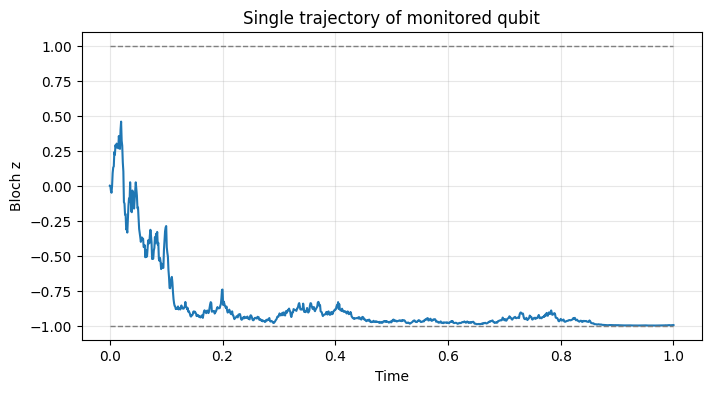

Entropy production Q for this trajectory: -5.377


In [153]:
# Initial state 1/sqrt(2) (|0> + |1>)
psi0 = np.array([1.0, 1.0], dtype=complex) / np.sqrt(2)

# Run a single trajectory and compute Q
z_traj, Q_single = sim.run_trajectory(psi0, compute_entropy=True)

# Time array for plotting
t_array = np.linspace(0, T, len(z_traj))

# Plot the z-coordinate
plt.figure(figsize=(8, 4))
plt.plot(t_array, z_traj, label='z(t) = σ_z')
plt.hlines(1.0, 0, T, linestyles='dashed', colors='grey', linewidth=1)
plt.hlines(-1.0, 0, T, linestyles='dashed', colors='grey', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Bloch z')
plt.title('Single trajectory of monitored qubit')
plt.ylim(-1.1, 1.1)
plt.grid(alpha=0.3)
plt.show()

print(f'Entropy production Q for this trajectory: {Q_single:.3f}')

## 3. Ensemble of trajectories and histogram of $Q$

We now run an ensemble of $N_{\text{traj}}$ trajectories and collect the entropy-production values $Q$. We display the resulting histogram and overlay the analytical distribution from Eq. (14), which depends only on the ratio $T/\tau = T\gamma$. Since the analytical expression is not normalised, we scale it numerically to unit area before plotting.

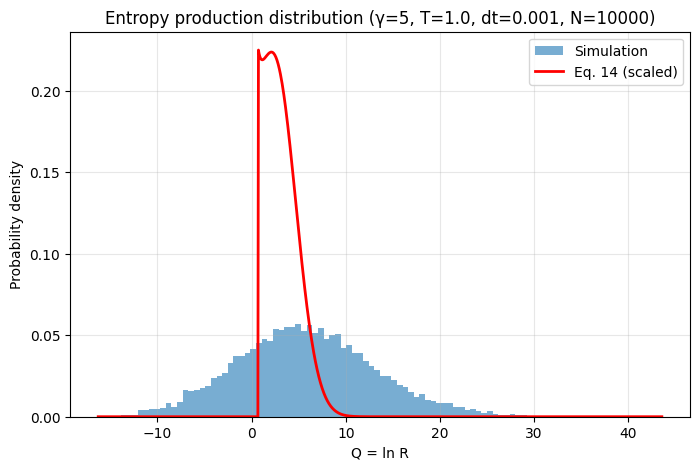

In [156]:
# Number of trajectories in the ensemble
n_traj = 10000

# Run the ensemble
_, Q_vals = sim.run_ensemble(psi0, n_traj)

# Plot histogram
fig, ax = plt.subplots(figsize=(8, 5))
counts, edges, _ = ax.hist(Q_vals, bins=100, density=True, alpha=0.6, label='Simulation')

# Analytical distribution on the same range
x_min, x_max = edges[0], edges[-1]
x_grid = np.linspace(x_min, x_max, 1000)
P = eq14_distribution(x_grid, gamma=gamma, T=T)
# Renormalise numerically
area = np.trapezoid(P, x_grid)
P_norm = P / area if area > 0 else P

# Plot analytical curve
ax.plot(x_grid, P_norm, 'r-', lw=2, label='Eq. 14 (scaled)')

ax.set_xlabel('Q = ln R')
ax.set_ylabel('Probability density')
ax.set_title(f'Entropy production distribution (γ={gamma}, T={T}, dt={dt}, N={n_traj})')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

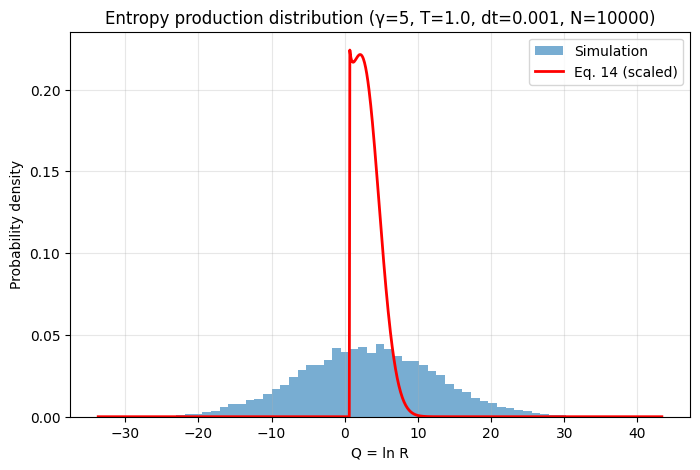

In [158]:
# Initialize with σ_z measurement instead of projector
from sse import sigma_z


sim2 = SingleQubitSSE(gamma=gamma, dt=dt, T=T, meas_op=sigma_z())
# Number of trajectories in the ensemble
n_traj = 10000

# Run the ensemble
_, Q_vals = sim2.run_ensemble(psi0, n_traj)

# Plot histogram
fig, ax = plt.subplots(figsize=(8, 5))
counts, edges, _ = ax.hist(Q_vals, bins='auto', density=True, alpha=0.6, label='Simulation')

# Analytical distribution on the same range
x_min, x_max = edges[0], edges[-1]
x_grid = np.linspace(x_min, x_max, 1000)
P = eq14_distribution(x_grid, gamma=gamma, T=T)
# Renormalise numerically
area = np.trapezoid(P, x_grid)
P_norm = P / area if area > 0 else P

# Plot analytical curve
ax.plot(x_grid, P_norm, 'r-', lw=2, label='Eq. 14 (scaled)')

ax.set_xlabel('Q = ln R')
ax.set_ylabel('Probability density')
ax.set_title(f'Entropy production distribution (γ={gamma}, T={T}, dt={dt}, N={n_traj})')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

The histogram of $Q$ from the simulated trajectories qualitatively follows the shape of the analytical distribution from Eq. (14). As the number of trajectories increases and the time step `dt` decreases, the agreement improves. Note that the analytical expression strictly applies to the case of no Hamiltonian drive and an initial state with zero $z$-component; however, its functional form still captures the heavy-tailed behaviour of the simulated distribution.